# Verification physical parameters estimations in CIGALE
In this file, we compare the results from [Vika et al.(2017)](https://ui.adsabs.harvard.edu/abs/2017A%26A...597A..51V/abstract) with the results from the Seyfert galaxy sample.
First, we import the Python packages.

In [1]:
%pylab

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
from astropy import units as u
from astroquery.vizier import Vizier
from astropy.coordinates import SkyCoord
from astropy.table import Table, join, hstack

We set a the row limit to -1 to obtain all the rows in the catalog 

In [3]:
Vizier.ROW_LIMIT = -1

## Obtaining the data

We obtain the catalog from Vika et al.(2017) directly from [Vizier](https://vizier.u-strasbg.fr/viz-bin/VizieR) and we also load the results from the Fritz AGN model with two viewing angles to compare them. We select this model for the comparison because is the most similar in the input parameters in CIGALE.

In [4]:
Vika17 = Vizier.get_catalogs('J/A+A/597/A51')[0]
ModelF37 = Table.read('../Data/Final/CIGALEOutputs/Cleanresults_Fr37.fits', format='fits')

We use also the basic information from the Seyfert catalog to match the catalogs in terms of coordinates

In [5]:
TV = Table.read('../Data/Final/VCV_SMB_otype.txt', format='ascii')
TV.rename_column('main_id', 'id')  # Renamed to use the join with the same id

In [6]:
FritzM = join(TV, ModelF37, keys='id')

In [7]:
CatalogVika = SkyCoord(ra=Vika17['RAJ2000'], dec=Vika17['DEJ2000'])
OurCatalog = SkyCoord(ra=FritzM['ra']*u.degree, dec=FritzM['dec']*u.degree)
idx, d2d, d3d = CatalogVika.match_to_catalog_sky(OurCatalog)

We select only galaxies that are separated between less than 3 arc seconds. Then, we stack the columns together.

In [8]:
MaxSep = 3.0 * u.arcsec
SepConstraint = d2d < MaxSep
Final = hstack([FritzM[idx[SepConstraint]], Vika17[SepConstraint]])
Final['MatchDist'] = d2d[SepConstraint].to(u.arcsec)

In [9]:
print('Total number of Matched galaxies:',len(Final))

Total number of Matched galaxies: 98


With this selection, it seems that we have a perfect match in terms of redshifts.

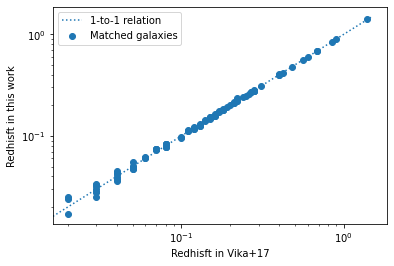

In [10]:
%matplotlib inline
scatter(Final['z_2'], Final['z_1'], label='Matched galaxies')
plot([0, 1.5], [0, 1.5], ls=':', label='1-to-1 relation')
xlabel('Redhisft in Vika+17')
ylabel('Redhisft in this work')
loglog()
legend()

## Comparisons of the parameters
We compare the main physical parameters (SFR, stellar mass, age, AGN fraction, AGN luminosity and dust luminosity). But first we check the $\chi_{\rm{red}}^{2}$ between the catalogs. 

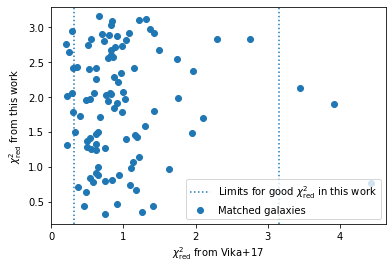

In [11]:
scatter(Final['chi2r'], Final['best.reduced_chi_square'],
        label='Matched galaxies')
axvline(x=10**-0.5, label=r'Limits for good $\chi_{\rm{red}}^{2}$ in this work',
        ls=':')
axvline(x=10**0.5, ls=':')
xlabel(r'$\chi_{\rm{red}}^{2}$ from Vika+17')
ylabel(r'$\chi_{\rm{red}}^{2}$ from this work')
legend()

We create some variables to decorate the 1-to-1 relations. We transform luminosities from W to solar luminosities and we calculate the values in log scale. 

In [12]:
ListParVika = ['M_', 'SFR', 'LAGN', 'fAGN', 'Ldust', 'Age']
ListParOur = ['bayes.stellar.m_star', 'bayes.sfh.sfr',
              'bayes.agn.luminosity', 'bayes.agn.fracAGN',
              'bayes.dust.luminosity', 'bayes.sfh.age']
ParmRang = [[9, 12.3], [-2.5, 3.9],
            [7.8, 13.5], [0, 1], [8.8, 13.5], [2.6, 4.1]]
ParmUnits = [r'Stellar Mass [M$_{\odot}$]', r'SFR [M$_{\odot}$/yr]',
             r'L$_{\rm{AGN}}$ [L$_{\odot}$]', 'AGN Fraction',
             r'L$_{\rm{dust}}$ [L$_{\odot}$]', 'Age [Myr]']
Particks = [[9,10,11,12],[-2,0,2,4],[8,9,10,11,12,13],[0,0.25,0.5,0.75,1],
           [9,10,11,12,13],[2.5,3,3.5,4]]
LocErr = [[9.5,11.5],[3,-1],[12.5,9],[0.85,0.25],[12.7,9.8],[2.9,3.8]]

In [13]:
for kisd in ['bayes.agn.luminosity', 'bayes.dust.luminosity']:
    Final[kisd] = (Final[kisd].data*u.W).to(u.solLum).value
    Final[kisd+'_err'] = (Final[kisd+'_err'].data *u.W).to(u.solLum).value
        
for kisd in ['LAGN','Ldust']:
    Final[kisd] = (Final[kisd]).to(u.solLum).value
    Final['e_'+kisd] = (Final['e_'+kisd]).to(u.solLum).value
    
for asdf in ['bayes.stellar.m_star', 'bayes.sfh.sfr', 'bayes.agn.luminosity', 
             'bayes.dust.luminosity', 'bayes.sfh.age']:
    Final[asdf+'_err'] = Final[asdf+'_err']/(Final[asdf] * log(10))
    Final[asdf] = log10(Final[asdf])
    
for asdf in ['M_', 'SFR', 'LAGN', 'Ldust', 'Age']:
    Final['e_'+asdf] = Final['e_'+asdf]/(Final[asdf] * log(10))
    Final[asdf] = log10(Final[asdf])

##### FIGURE 3
Finally, we compare the six physical parameters.

In [14]:
%matplotlib
# with plt.style.context('seaborn-talk'):
with plt.style.context('seaborn-paper'):
    plt.rcParams.update({'font.size': 12})
    plt.rcParams.update({'axes.labelsize': 12})
    plt.rcParams.update({'legend.fontsize': 10})
    plt.rcParams.update({'ytick.labelsize': 10})
    plt.rcParams.update({'xtick.labelsize': 10})
    fig, ((ax1, ax2),
          (ax3, ax4),
          (ax5, ax6)) = plt.subplots(3, 2, figsize=(6.75, 9.44))
    axs = [ax1, ax2, ax3, ax4, ax5, ax6]
    for iPar in range(6):
        Xerr = np.median(Final['e_'+ListParVika[iPar]])
        Yerr = np.median(Final[ListParOur[iPar]+'_err'])
        axs[iPar].errorbar(LocErr[iPar][0],LocErr[iPar][1],
                          xerr=Xerr,yerr=Yerr,c='gray')
        axs[iPar].scatter(Final[ListParVika[iPar]], Final[ListParOur[iPar]],
                          s=10, label='Matched galaxies')
        axs[iPar].plot(ParmRang[iPar], ParmRang[iPar],
                       ls=':', label='1-to-1 relation', c='gray')
        axs[iPar].set_xlabel(ParmUnits[iPar]+' (Vika+17)')
        axs[iPar].set_ylabel(ParmUnits[iPar]+' (This work)')
        axs[iPar].axis('equal')
        axs[iPar].set_xlim(ParmRang[iPar][0],ParmRang[iPar][1])
        axs[iPar].set_ylim(ParmRang[iPar][0],ParmRang[iPar][1])
        axs[iPar].set_xticks(Particks[iPar])
        axs[iPar].set_yticks(Particks[iPar])
plt.subplots_adjust(wspace=0.5, hspace=0.4)
# savefig('../Figures/F3.pdf', dpi=300, bbox_inches='tight')  # For Paper
# savefig('../Talk_Figures/F3.png',dpi=300,bbox_inches = 'tight') ## For Presentation

Using matplotlib backend: Qt5Agg


/Users/users/ramos/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


In [15]:
Outlier = np.where(Final['bayes.sfh.sfr'] < -3)[0]
print('The galaxy not show in the SFR plot is %s with a SFR=%.2f in this work' 
      % (Final['id'][Outlier][0],Final['bayes.sfh.sfr'][Outlier]))

The galaxy not show in the SFR plot is 2MASX J17422161+5529215 with a SFR=-4.77 in this work


In [16]:
%load_ext watermark
%watermark -a "Andres Ramos" -d -v -m
print('Specific Python packages')
%watermark -iv -w --packages astroquery

Author: Andres Ramos

Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.16.1

Compiler    : GCC 7.3.0
OS          : Linux
Release     : 3.10.0-1160.25.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit

Specific Python packages
astroquery: 0.4.1

matplotlib: 3.2.2
sys       : 3.8.3 (default, Jul  2 2020, 16:21:59) 
[GCC 7.3.0]
autopep8  : 1.5.4
logging   : 0.5.1.2
re        : 2.2.1
json      : 2.0.9
numpy     : 1.19.5
astropy   : 4.2

Watermark: 2.1.0

